# ASC regimes for control and easterlies perturbations

The velocity data are calculated and saved in `calc_ASC_1000m_isobath.ipynb` and are a climatology of the last 5 years of the simulation (2160-2164).

The regime classification considers the orientation of the barotropic along-slope velocity as well as whether the flow is surface-intensified or bottom-intensified. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu
from collections import Counter
import more_itertools

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34863 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 22.46 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-58)

Along-slope velocity along 1000m isobath

In [26]:
file_path = '/g/data/x77/wgh581/Analysis/easterlies-collaborative-project/notebooks/ASC/'
# Load dataset
file_name = 'Antarctic_slope_1000m_contour_con.npz'
data_con  = np.load(file_path+file_name)
file_name = 'Antarctic_slope_1000m_contour_up.npz'
data_up   = np.load(file_path+file_name)
file_name = 'Antarctic_slope_1000m_contour_down.npz'
data_down = np.load(file_path+file_name)
# Velocity
u_con      = data_con['u_along_contour']
u_btr_con  = data_con['u_btr_contour']
u_up       = data_up['u_along_contour']
u_btr_up   = data_up['u_btr_contour']
u_down     = data_down['u_along_contour']
u_btr_down = data_down['u_btr_contour']
# Other info
st_ocean  = data_con['st_ocean']
lat_along_contour = data_con['lat_along_contour']
lon_along_contour = data_con['lon_along_contour']
distance  = data_con['distance_along_contour']
thickness = data_con['thickness_contour']
num_points = data_con['num_points']
# Print available info in dataset
data_con.files

['u_along_contour',
 'u_btr_contour',
 'lat_along_contour',
 'lon_along_contour',
 'num_points',
 'distance_along_contour',
 'st_ocean',
 'thickness_contour']

In [9]:
distance[-1] = distance[-2]+1

Annual mean

In [10]:
u_con      = u_con.mean(axis=0)
u_btr_con  = u_btr_con.mean(axis=0)
u_up       = u_up.mean(axis=0)
u_btr_up   = u_btr_up.mean(axis=0)
u_down     = u_down.mean(axis=0)
u_btr_down = u_btr_down.mean(axis=0)

Depth information

In [11]:
# Array that has the depth levels
depth_array = np.zeros((np.size(u_con,0), np.size(u_con,1)))
for ii in range(np.size(u_con,1)):
    depth_array[:,ii] = u_con[:,ii] * 0 + st_ocean
# Get max depth of data (skipping nans)
max_depth = np.nanmax(depth_array, axis=0) 

In [12]:
st_ocean_2d = np.tile(st_ocean, (np.size(thickness, 1),1)).transpose()

Define some functions

In [13]:
# Function to smooth data alogn the 1000 m isobath
def running_mean_2d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0],np.shape(in_data)[1]))
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data[yy,:], 0, np.nan))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

def running_mean_1d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0]))
    cumsum_tmp = np.nancumsum(np.insert(in_data, 0, np.nan))
    out_data[int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

In [14]:
# Function to calculate regimes

def calculate_ASC_regimes(data_full, data_btr):

    # Smooth velocity along the 1000 m isobath
    N = 20
    data_smoothed     = running_mean_2d(data_full, N)
    data_btr_smoothed = running_mean_1d(data_btr, N)
    
    # Surface-intensified prograde flow: 0
    ASC_regimes_tmp = np.zeros(num_points)
    
    # Bottom-intensified prograde flow: 1
    upper_depth = 200 # m
    lower_depth = 200 # m
    n_val = 0.5
    thickness_lower = np.where(st_ocean_2d >= max_depth-lower_depth, thickness, np.nan)
    u_lower         = np.where(st_ocean_2d >= max_depth-lower_depth, data_smoothed, np.nan)
    thickness_upper = np.where(st_ocean_2d <= upper_depth, thickness, np.nan)
    u_upper         = np.where(st_ocean_2d <= upper_depth, data_smoothed, np.nan)
    # Vertical averaging
    u_lower = np.nansum(u_lower * thickness_lower, axis=0) / np.nansum(thickness_lower, axis=0)
    u_upper = np.nansum(u_upper * thickness_upper, axis=0) / np.nansum(thickness_upper, axis=0)
    # Check if surface flow < bottom flow
    ASC_regimes_tmp[np.abs(u_upper)*n_val <= np.abs(u_lower)] = 1
    
    # Retrograde flow: 2
    ASC_regimes_tmp[data_btr_smoothed > 0] = 2

    # Along-slope smoothing of ASC regimes
    windowed_ASC_regimes_tmp = list(more_itertools.windowed(ASC_regimes_tmp, n=N))
    # Create a new (final) array for the regime information and give it the predominant value from that window
    ASC_regimes = np.zeros(num_points)
    for ii in range(np.size(windowed_ASC_regimes_tmp, 0)-1):
        tmp = Counter(windowed_ASC_regimes_tmp[ii]).most_common(1)[0][0]
        ASC_regimes[ii+int(N/2)] = tmp
    
    # Finished
    return ASC_regimes

In [15]:
# Control
ASC_regimes_con = calculate_ASC_regimes(u_con, u_btr_con)
# Easterlies UP
ASC_regimes_up = calculate_ASC_regimes(u_up, u_btr_up)
# Easterlies DOWN
ASC_regimes_down = calculate_ASC_regimes(u_down, u_btr_down)

# In one array
ASC_regimes = np.vstack((ASC_regimes_down, ASC_regimes_up, ASC_regimes_con))

Plot ASC regimes

In [16]:
ft_size   = 16
title_name = ['u_along control', 'u_along change for easterlies increase', 'u_along change for easterlies decrease']

In [17]:
# Costum colormap
import matplotlib
# colorsList_no4 = [('lightgreen'),('blueviolet'),('tomato'),('c')]
# CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('lightgreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

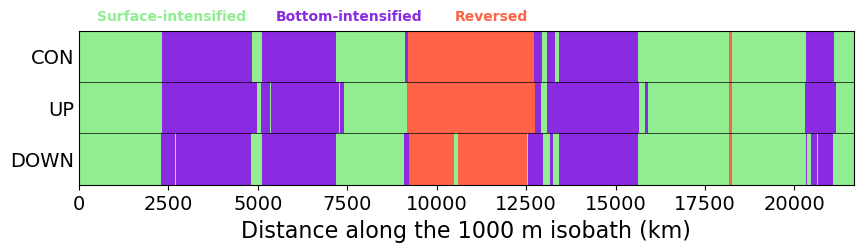

In [50]:
fig = plt.figure(figsize=(10,2))

ax = plt.subplot(111)
plt.pcolormesh(distance, np.arange(0, 4, 1), ASC_regimes, cmap=CustomCmap_no3)
plt.xlabel('Distance along the 1000 m isobath (km)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size-2)
plt.yticks(ticks=np.arange(0.5, 3, 1), labels=['DOWN', 'UP', 'CON'])
plt.axhline(1, color='k', linewidth=0.5)
plt.axhline(2, color='k', linewidth=0.5)
plt.tick_params(axis='y', length = 0)

plt.text(500, 3.2, 'Surface-intensified', color='lightgreen', fontweight='bold')
plt.text(5500, 3.2, 'Bottom-intensified', color='blueviolet', fontweight='bold')
plt.text(10500, 3.2, 'Reversed', color='tomato', fontweight='bold')

# Save figure
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_regimes_easterlies_pert.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Things to note:
- Little change between the control run and the easterlies perturbations
- UP case: bottom-intensified ASC extended (mostly upstream end)
- DOWN case: bottom-intensified ASC slightly less, replaced by surface-intensified ASC

---

## Seasonality per regime for each simulation

In [29]:
print(np.shape(ASC_regimes))
print(np.shape(u_btr_con))

(3, 4487)
(12, 4487)


In [31]:
# Get indices of where regime shifts occur
regime_shift = np.diff(ASC_regimes)
index_regime_change_con  = [i for i in range(len(regime_shift[0,:])) if regime_shift[0,i] != 0]
index_regime_change_up   = [i for i in range(len(regime_shift[1,:])) if regime_shift[1,i] != 0]
index_regime_change_down = [i for i in range(len(regime_shift[2,:])) if regime_shift[2,i] != 0]

In [32]:
def get_regime_average(in_data):
    out_data = np.zeros((3,12))
    for tt in range(12):
        out_data[0,tt] = np.nanmean(np.where(ASC_regimes==0, in_data[tt,:], np.nan))
        out_data[1,tt] = np.nanmean(np.where(ASC_regimes==1, in_data[tt,:], np.nan))
        out_data[2,tt] = np.nanmean(np.where(ASC_regimes==2, in_data[tt,:], np.nan))
    # Finished
    return out_data

In [63]:
seasonality_btr_con  = get_regime_average(u_btr_con)
seasonality_btr_up   = get_regime_average(u_btr_up)
seasonality_btr_down = get_regime_average(u_btr_down)

In [61]:
# 3 month rnning mean
def running_mean_1d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0]))
    cumsum_tmp = np.nancumsum(np.insert(in_data, 0, np.nan))
    var = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    out_data[int(N/2):-int(N/2)] = var
    # Finished
    return out_data

def calc_running_mean_full(in_data, N):
    out_data = np.zeros((3,12))
    for ii in range(3):
        out_data[ii,:] = running_mean_1d(in_data[ii,:], N)
        # First value:
        out_data[ii,0] = (in_data[ii,-1] + np.nansum(in_data[ii,:2])) / N
        # Last value:
        out_data[ii,-1] = (in_data[ii,0] + np.nansum(in_data[ii,-2:])) / N
    # Finished
    return out_data

In [64]:
seasonality_btr_con  = calc_running_mean_full(seasonality_btr_con, 3)
seasonality_btr_up   = calc_running_mean_full(seasonality_btr_up, 3)
seasonality_btr_down = calc_running_mean_full(seasonality_btr_down, 3)

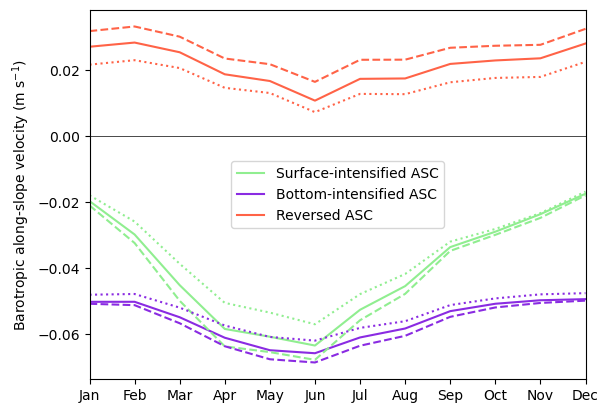

In [77]:

regime_name = ['Surface-intensified ASC', 'Bottom-intensified ASC', 'Reversed ASC']
regime_clr = ['lightgreen', 'blueviolet', 'tomato']
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = plt.figure()
for ii in range(3):
    plt.plot(seasonality_btr_con[ii,:], color=regime_clr[ii], label=regime_name[ii])
plt.legend()
for ii in range(3):
    plt.plot(seasonality_btr_up[ii,:], color=regime_clr[ii], linestyle='--')
for ii in range(3):
    plt.plot(seasonality_btr_down[ii,:], color=regime_clr[ii], linestyle=':')
plt.xlim(0, 11)
plt.axhline(0, color='k', linewidth='0.5')
plt.ylabel('Barotropic along-slope velocity (m s$^{-1}$)')
plt.xticks(ticks=np.arange(0, 12, 1), labels=month)

# Save figure
save_fig = 1
if save_fig == 1:
    fig_path = '/g/data/x77/wgh581/Analysis/easterlies-collaborative-project/notebooks/ASC/'
    fig_name = 'Fig_ASC_regimes_easterlies_pert_seasonality_btr.png'
    plt.savefig(fig_path+fig_name, dpi=150, bbox_inches='tight', facecolor='white')